In [1]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

## 최근 영업일 구하는 함수

In [2]:
def last_business_day() :
    import requests as rq
    from bs4 import BeautifulSoup
    
    url = 'https://finance.naver.com/sise/sise_deposit.naver'
    data = rq.get(url)
    data_html = BeautifulSoup(data.content)

    parse_day = data_html.select_one(
        'div.subtop_sise_graph2 > ul.subtop_chart_note > li > span.tah').text
    # print(parse_day)

    # 날짜. 즉, 숫자 데이터만 클랜징
    import re
    global biz_day
    biz_day = re.findall('[0-9]+', parse_day)
    biz_day = ''.join(biz_day)
    print(f'Done. "biz_day" : {biz_day}')

In [3]:
last_business_day()

Done. "biz_day" : 20241011


In [4]:
biz_day = biz_day[:4] + '-' + biz_day[4:6] + '-' + biz_day[6:]
biz_day

'2024-10-11'

## 티커 csv 불러오기

In [5]:
### 티커 정보 불러오기

import pandas as pd

what_tic = input('[1] 자산군 or [2] 섹터 or [3] 커스텀 : ')

if what_tic == '1' :
    what_tic = 'assets'
elif what_tic == '2' :
    what_tic = 'sectors'
elif what_tic == '3' :
    what_tic = 'custom'
else :
    print('잘못된 입력입니다.')

tickers = pd.read_csv(f'/Users/leesangwon/documents/{what_tic}_ticker.csv')

# 티커 칼럼 리스트화
tickers_list = tickers['티커'].tolist() if '티커' in tickers.columns else tickers.iloc[:, 0].tolist()
tickers


,종목명,티커
0,코스피,^KS11
1,코스피200,^KS200
2,나스닥,^IXIC
3,S&P,^GSPC
4,상하이,000001.SS
5,닛케이,^N225
6,유로넥스트,^N100
7,런던증권,^FTSE
8,미국3년,^IRX
9,미국10년,^TNX


## 주가 데이터 로드

[*********************100%***********************]  18 of 18 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 269 entries, 2023-10-02 00:00:00+00:00 to 2024-10-10 00:00:00+00:00
Freq: B
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   상하이     244 non-null    float64
 1   한국3년    246 non-null    float64
 2   한국10년   246 non-null    float64
 3   한국30년   246 non-null    float64
 4   WTI     259 non-null    float64
 5   농산물     259 non-null    float64
 6   금       259 non-null    float64
 7   원달러     268 non-null    float64
 8   런던증권    261 non-null    float64
 9   S&P     259 non-null    float64
 10  미국3년    259 non-null    float64
 11  나스닥     259 non-null    float64
 12  코스피     248 non-null    float64
 13  코스피200  248 non-null    float64
 14  유로넥스트   263 non-null    float64
 15  닛케이     252 non-null    float64
 16  미국10년   259 non-null    float64
 17  미국30년   259 non-null    float64
dtypes: float64(18)
memory usage: 39.9 KB


<Axes: >

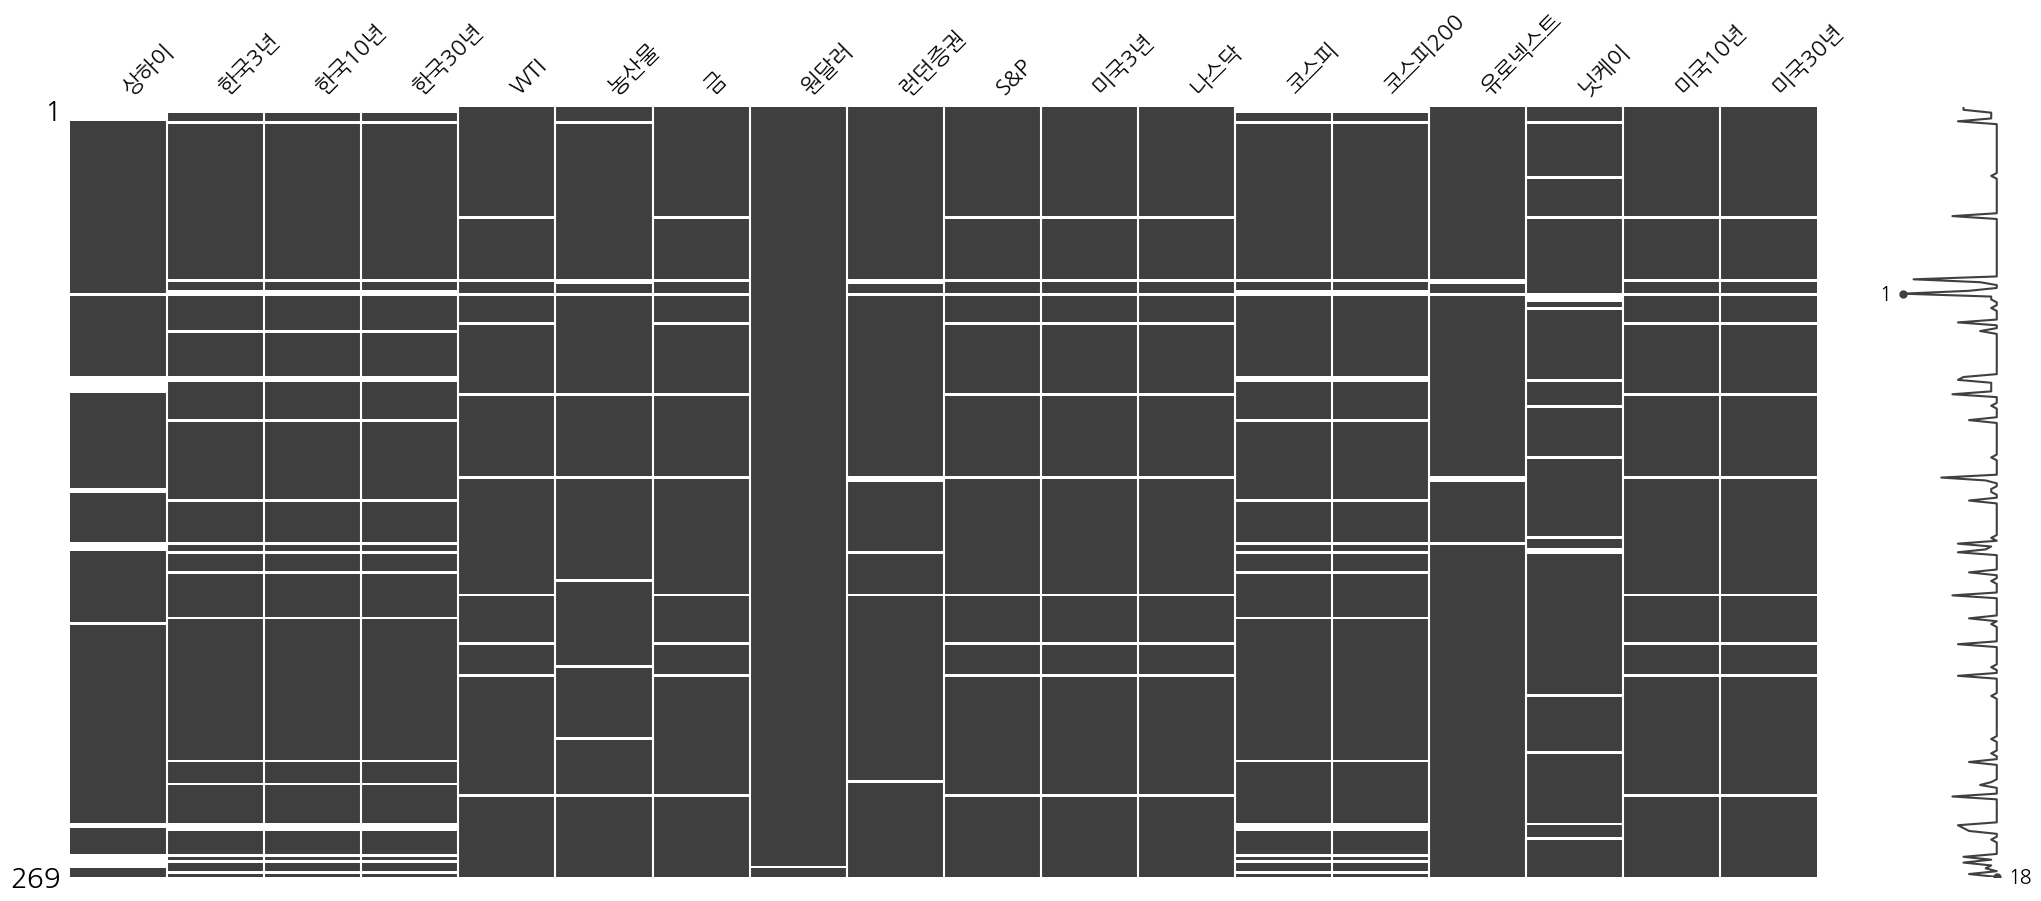

In [11]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import missingno as msno

start_y_m = input('조회시작 년-월 입력 (2001-06 형식) :  ')

start = start_y_m + '-01'
end = biz_day
symbol = tickers_list

prices = yf.download(symbol, start, end)['Adj Close']

# 상관분석을 위해 주가 스케일링
scaler = MinMaxScaler()
prices_scaled = pd.DataFrame(scaler.fit_transform(prices), columns=prices.columns, index=prices.index)

# 티커를 주식명으로 매핑
ticker_to_name = dict(zip(tickers['티커'], tickers['종목명']))
# prices_scaled의 칼럼명(티커)을 "종목명"으로 변환
prices_scaled.rename(columns=ticker_to_name, inplace=True)

# null값 확인
print()
prices_scaled.info()
msno.matrix(prices_scaled)

## 시각화

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


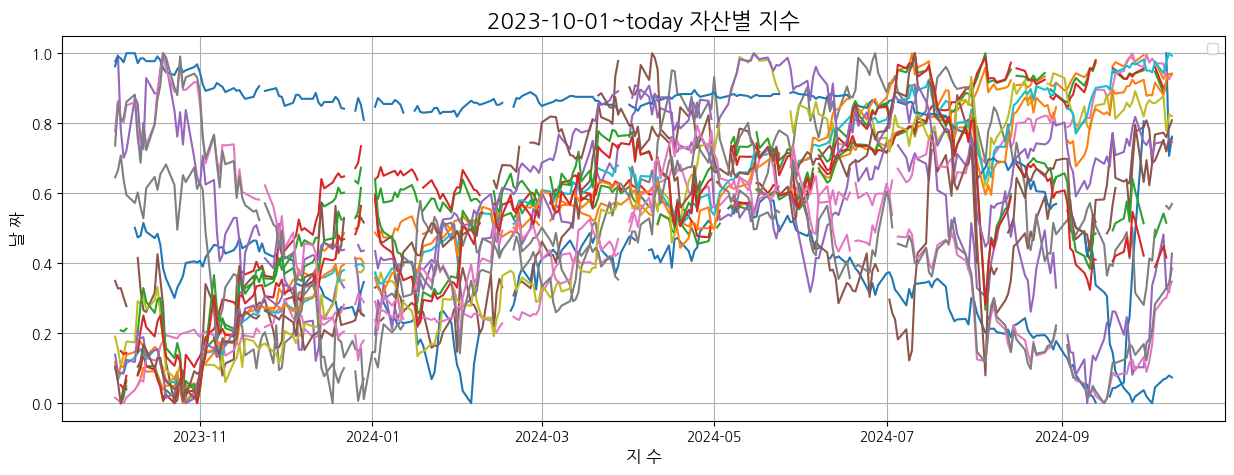

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(prices_scaled)

plt.title(f'{start}~today 자산별 지수', fontsize=16)
plt.xlabel('지 수', fontsize=12)
plt.ylabel('날 짜', fontsize=12)

plt.legend()
plt.grid(True)

# 출력
plt.show()

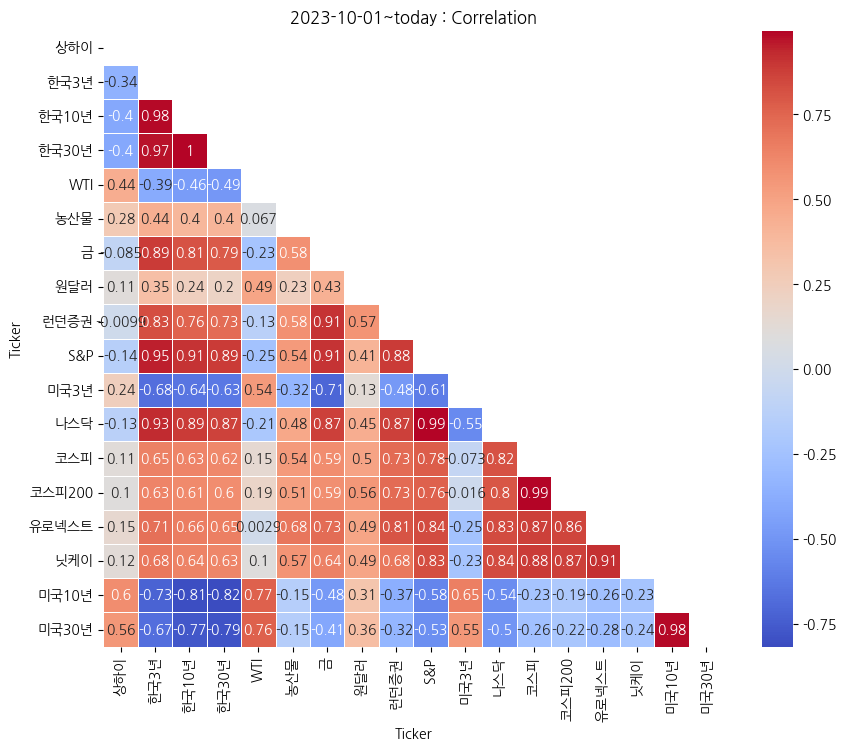

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = prices_scaled.corr()

# 상삼각형 마스킹
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'{start}~today : Correlation')
plt.show()

In [14]:
low_corr_pairs = []

# 상관계수 행렬을 반복하며 조건에 맞는 항목 추출
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if np.abs(corr_value) <= 0.2:  # 절댓값 값 설정 (ex) 0.2
            low_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_value))

low_corr_assets_ticker = pd.DataFrame(low_corr_pairs, columns=['자산 1', '자산 2', '상관계수'])

# 상관계수 소수점 3자리로 반올림
low_corr_assets_ticker['상관계수'] = low_corr_assets_ticker['상관계수'].round(2)
# 상관계수 절댓값 기준으로 오름차순
low_corr_assets_ticker['절댓값'] = np.abs(low_corr_assets_ticker['상관계수'])
low_corr_df_sorted = low_corr_assets_ticker.sort_values(by='절댓값')
# 절댓값 칼럼 삭제
low_corr_df_sorted = low_corr_df_sorted.drop(columns=['절댓값'])

# 출력
low_corr_df_sorted

,자산 1,자산 2,상관계수
13,WTI,유로넥스트,0.00
2,상하이,런던증권,-0.01
19,미국3년,코스피200,-0.02
18,미국3년,코스피,-0.07
9,WTI,농산물,0.07
0,상하이,금,-0.08
6,상하이,코스피200,0.10
14,WTI,닛케이,0.10
1,상하이,원달러,0.11
5,상하이,코스피,0.11


In [15]:
# 태블로 시각화를 위한 csv저장
prices_scaled.to_csv(f'/Users/leesangwon/documents/test_price_scaled_{start_y_m}.csv')